In [24]:
import numpy as np 
import pandas as pd 
import os 
import pickle
import json 
import math 
from transformers import (
    AdamW, 
    AutoConfig, 
    AutoModel, 
    AutoModelForSequenceClassification,
    AutoTokenizer, 
    get_linear_schedule_with_warmup
)
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from tqdm.auto import tqdm
import ccxt
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas_ta as ta
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score 
# classification models 
import xgboost
from xgboost import XGBClassifier  

In [2]:
with open("deberta_news_embeddings.pickle", "rb") as f: 
    deberta_embeddings = pickle.load(f) 

In [3]:
with open("BTC_USDT-4h-11.json") as f: 
    d = json.load(f) 
    
chart_df = pd.DataFrame(d) 
chart_df = chart_df.rename(columns={0:"timestamp", 
                                    1:"open",
                                    2:"high",
                                    3:"low",
                                    4:"close",
                                    5:"volume"}) 

def process(df): 
    binance = ccxt.binance() 
    dates = df["timestamp"].values 
    timestamp = [] 
    for i in range(len(dates)):
        date_string = binance.iso8601(int(dates[i]))
        date_string = date_string[:10] + " " + date_string[11:-5] 
        timestamp.append(date_string) 
    df["datetime"] = timestamp 
    df = df.drop(columns={"timestamp"})  
    return df 

chart_df = process(chart_df) 

hours, days, months, years = [], [], [], [] 
for dt in tqdm(chart_df["datetime"]): 
    hour = pd.to_datetime(dt).hour 
    day = pd.to_datetime(dt).day 
    month = pd.to_datetime(dt).month 
    year = pd.to_datetime(dt).year 
    hours.append(hour) 
    days.append(day) 
    months.append(month) 
    years.append(year)  

chart_df["hour"] = hours 
chart_df["day"] = days 
chart_df["month"] = months  
chart_df["year"] = years 

chart_df.head()

  0%|          | 0/11235 [00:00<?, ?it/s]

,open,high,low,close,volume,datetime,hour,day,month,year
0,4261.48,4349.99,4261.32,4349.99,82.088865,2017-08-17 04:00:00,4,17,8,2017
1,4333.32,4485.39,4333.32,4427.30,63.619882,2017-08-17 08:00:00,8,17,8,2017
2,4436.06,4485.39,4333.42,4352.34,174.562001,2017-08-17 12:00:00,12,17,8,2017
3,4352.33,4354.84,4200.74,4325.23,225.109716,2017-08-17 16:00:00,16,17,8,2017
4,4307.56,4369.69,4258.56,4285.08,249.769913,2017-08-17 20:00:00,20,17,8,2017


In [4]:
chart_datestr = {} 
chart_newscnt = {} 
years = chart_df["year"].values 
months = chart_df["month"].values 
days = chart_df["day"].values 
hours = chart_df["hour"].values 

cnt = 0 

# Sum of Embeddings 
for i in tqdm(range(len(years))): 
    datestr = str(years[i]) + '/' + str(months[i]) + '/' + str(days[i]) + '/' + str(hours[i]) 
    if hours[i] == 4:
        partial = str(years[i]) + '/' + str(months[i]) + '/' + str(days[i]) + '/'  
        cnt = 0 # for calculating average 
        for d in [partial+str(i) for i in range(0,4)]:
            if d in deberta_embeddings.keys():
                if datestr not in chart_datestr.keys(): 
                    chart_datestr[datestr] = torch.tensor([0 for _ in range(768)], dtype=torch.float32)
                for arr in deberta_embeddings[d]:
                    chart_datestr[datestr] += arr 
    elif hours[i] == 8:
        partial = str(years[i]) + '/' + str(months[i]) + '/' + str(days[i]) + '/'  
        for d in [partial+str(i) for i in range(4,8)]:
            if d in deberta_embeddings.keys():
                if datestr not in chart_datestr.keys(): 
                    chart_datestr[datestr] = torch.tensor([0 for _ in range(768)], dtype=torch.float32)
                for arr in deberta_embeddings[d]:
                    chart_datestr[datestr] += arr 
    elif hours[i] == 12:
        partial = str(years[i]) + '/' + str(months[i]) + '/' + str(days[i]) + '/'  
        for d in [partial+str(i) for i in range(8,12)]:
            if d in deberta_embeddings.keys():
                if datestr not in chart_datestr.keys(): 
                    chart_datestr[datestr] = torch.tensor([0 for _ in range(768)], dtype=torch.float32)
                for arr in deberta_embeddings[d]:
                    chart_datestr[datestr] += arr 
    elif hours[i] == 16:
        partial = str(years[i]) + '/' + str(months[i]) + '/' + str(days[i]) + '/'  
        for d in [partial+str(i) for i in range(12,16)]:
            if d in deberta_embeddings.keys():
                if datestr not in chart_datestr.keys(): 
                    chart_datestr[datestr] = torch.tensor([0 for _ in range(768)], dtype=torch.float32)
                for arr in deberta_embeddings[d]:
                    chart_datestr[datestr] += arr 
    elif hours[i] == 20:
        partial = str(years[i]) + '/' + str(months[i]) + '/' + str(days[i]) + '/'  
        for d in [partial+str(i) for i in range(16,20)]:
            if d in deberta_embeddings.keys():
                if datestr not in chart_datestr.keys(): 
                    chart_datestr[datestr] = torch.tensor([0 for _ in range(768)], dtype=torch.float32)
                for arr in deberta_embeddings[d]:
                    chart_datestr[datestr] += arr 
    elif hours[i] == 0: 
        partial = str(years[i]) + '/' + str(months[i]) + '/' + str(days[i]) + '/'  
        for d in [partial+str(i) for i in range(20,24)]:
            if d in deberta_embeddings.keys():
                if datestr not in chart_datestr.keys(): 
                    chart_datestr[datestr] = torch.tensor([0 for _ in range(768)], dtype=torch.float32)
                for arr in deberta_embeddings[d]:
                    chart_datestr[datestr] += arr  

  0%|          | 0/11235 [00:00<?, ?it/s]

In [5]:
embeddings = [] 
for i in tqdm(range(len(years)), position=0, leave=True):
    datestr = str(years[i]) + "/" + str(months[i]) + "/" + str(days[i]) + "/" + str(hours[i]) 
    if datestr in chart_datestr.keys(): 
        v = chart_datestr[datestr].numpy()[0]  
        embeddings.append(v)
    else:
        embeddings.append([0 for _ in range(768)])  

  0%|          | 0/11235 [00:00<?, ?it/s]

In [6]:
chart_df[[f"text_{i+1}" for i in np.arange(768)]] = embeddings

/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [7]:
chart_df.head()

,open,high,low,close,volume,datetime,hour,day,month,year,...,text_759,text_760,text_761,text_762,text_763,text_764,text_765,text_766,text_767,text_768
0,4261.48,4349.99,4261.32,4349.99,82.088865,2017-08-17 04:00:00,4,17,8,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4333.32,4485.39,4333.32,4427.30,63.619882,2017-08-17 08:00:00,8,17,8,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4436.06,4485.39,4333.42,4352.34,174.562001,2017-08-17 12:00:00,12,17,8,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4352.33,4354.84,4200.74,4325.23,225.109716,2017-08-17 16:00:00,16,17,8,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4307.56,4369.69,4258.56,4285.08,249.769913,2017-08-17 20:00:00,20,17,8,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
chart_df.to_csv("chart_df_with_embeddings.csv",index=False)

In [9]:
# feature engineer chart data 
chart_df = pd.read_csv("chart_df_with_embeddings.csv") 
targets = [] 
high = chart_df["high"].values 
low = chart_df["low"].values 
close = chart_df["close"].values 

threshold = 0.0075

for i in range(len(close)-1):
    high_vol = (high[i+1] - close[i]) / close[i] 
    low_vol = (low[i+1] - close[i]) / close[i] 
    if abs(high_vol) >= abs(low_vol) and high_vol >= threshold: 
        targets.append(0) 
    elif abs(high_vol) < abs(low_vol) and low_vol <= -threshold:
        targets.append(1)  
    else:
        targets.append(2) 
        
targets.append(None) 

chart_df["Targets"] = targets 

In [10]:
chart_df.set_index(pd.DatetimeIndex(chart_df["datetime"]), inplace=True)

### addition of chart features ### 
chart_df["bop"] = chart_df.ta.bop(lookahead=False) 
chart_df["ebsw"] = chart_df.ta.ebsw(lookahead=False) 
chart_df["cmf"] = chart_df.ta.cmf(lookahead=False) 
chart_df["vwap"] = chart_df.ta.vwap(lookahead=False) 
chart_df["rsi/100"] = chart_df.ta.rsi(lookahead=False) / 100
chart_df["high/low"] = chart_df["high"] / chart_df["low"] 
chart_df["close/open"] = chart_df["close"] / chart_df["open"] 
chart_df["high/open"] = chart_df["high"] / chart_df["open"] 
chart_df["low/open"] = chart_df["low"] / chart_df["open"] 
chart_df["hwma"] = chart_df.ta.hwma(lookahead=False) 
chart_df["linreg"] = chart_df.ta.linreg(lookahead=False) 
chart_df["hwma/close"] = chart_df["hwma"] / chart_df["close"] 
chart_df["linreg/close"] = chart_df["linreg"] / chart_df["close"] 

    
### addition of recent differenced features ### 
for l in range(1, 12): 
    #for col in ["open", "high", "low", "close", "volume", "vwap"]:
    for col in ["high", "low", "volume", "vwap"]:
        val = chart_df[col].values 
        val_ret = [None for _ in range(l)]
        for i in range(l, len(val)):
            if val[i-l] == 0: 
                ret = 1 
            else:
                ret = val[i] / val[i-l]  
            val_ret.append(ret) 
        chart_df["{}_change_{}".format(col, l)] = val_ret
        
### drop unnecessary columns ### 
chart_df.drop(columns={"open","high","low","close","volume","vwap","linreg","hwma","datetime","year"}, inplace=True) 


chart_df.dropna(inplace=True)

print(chart_df.shape)  

(11195, 826)


In [11]:
columns = chart_df.columns 

train_columns = [] 

for c in columns:
    if c not in ["Targets"]: 
        train_columns.append(c) 
        
        
train_idx = int(chart_df.shape[0] * 0.8) 
val_idx = int(chart_df.shape[0] * 0.1)
train_df, val_df, test_df = chart_df.iloc[:train_idx], chart_df.iloc[train_idx:train_idx+val_idx], chart_df.iloc[train_idx+val_idx:]


train_df.shape, val_df.shape, test_df.shape


((8956, 826), (1119, 826), (1120, 826))

In [12]:
X_train = train_df[train_columns] 
Y_train = train_df["Targets"]

X_val = val_df[train_columns] 
Y_val = val_df["Targets"] 

X_test = test_df[train_columns] 
Y_test = test_df["Targets"] 


class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(Y_train),
                                     y = Y_train) 

print(f"class weights: {class_weights}") 

class weights: [0.87137575 0.82195301 1.57288374]


In [14]:
d = {0:class_weights[0], 1:class_weights[1], 2:class_weights[2]}

clf = XGBClassifier(silent=False, 
                    n_estimators=1000,
                    class_weight=d, 
                    metric="logloss", 
                    tree_method="gpu_hist")

clf.fit(X_train, 
        Y_train, 
        eval_set=[(X_val, Y_val)],
        verbose=100) 

[08:08:50] WARNING: ../src/learner.cc:576: 
Parameters: { "class_weight", "metric", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:08:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07214
[100]	validation_0-mlogloss:1.19331
[200]	validation_0-mlogloss:1.30825
[300]	validation_0-mlogloss:1.39127
[400]	validation_0-mlogloss:1.44341
[500]	validation_0-mlogloss:1.49381
[600]	validation_0-mlogloss:1.54149
[700]	validation_0-mlogloss:1.58874
[800]	validation_0-mlogloss:1.61714
[900]	validation_0-mlogloss:1.64487
[999]	

XGBClassifier(base_score=0.5, booster='gbtree',
              class_weight={0: 0.8713757540377506, 1: 0.8219530102790015,
                            2: 1.572883737267299},
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, metric='logloss',
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, silent=False,
              subsample=1, tree_method='gpu_hist', ...)

In [15]:
Y_pred = clf.predict(X_test) 
cnt = 0 
for i in range(len(Y_pred)):
    if Y_pred[i] == Y_test.values[i]:
        cnt += 1 
        
print("accuracy = {}%".format(cnt / len(Y_pred) * 100.))


accuracy = 43.30357142857143%


In [27]:
print(f1_score(Y_test.values, Y_pred, average="macro")) 
print(f1_score(Y_test.values, Y_pred, average="micro")) 
print(f1_score(Y_test.values, Y_pred, average="weighted"))

0.40989631764599443
0.4330357142857143
0.4274790810667885


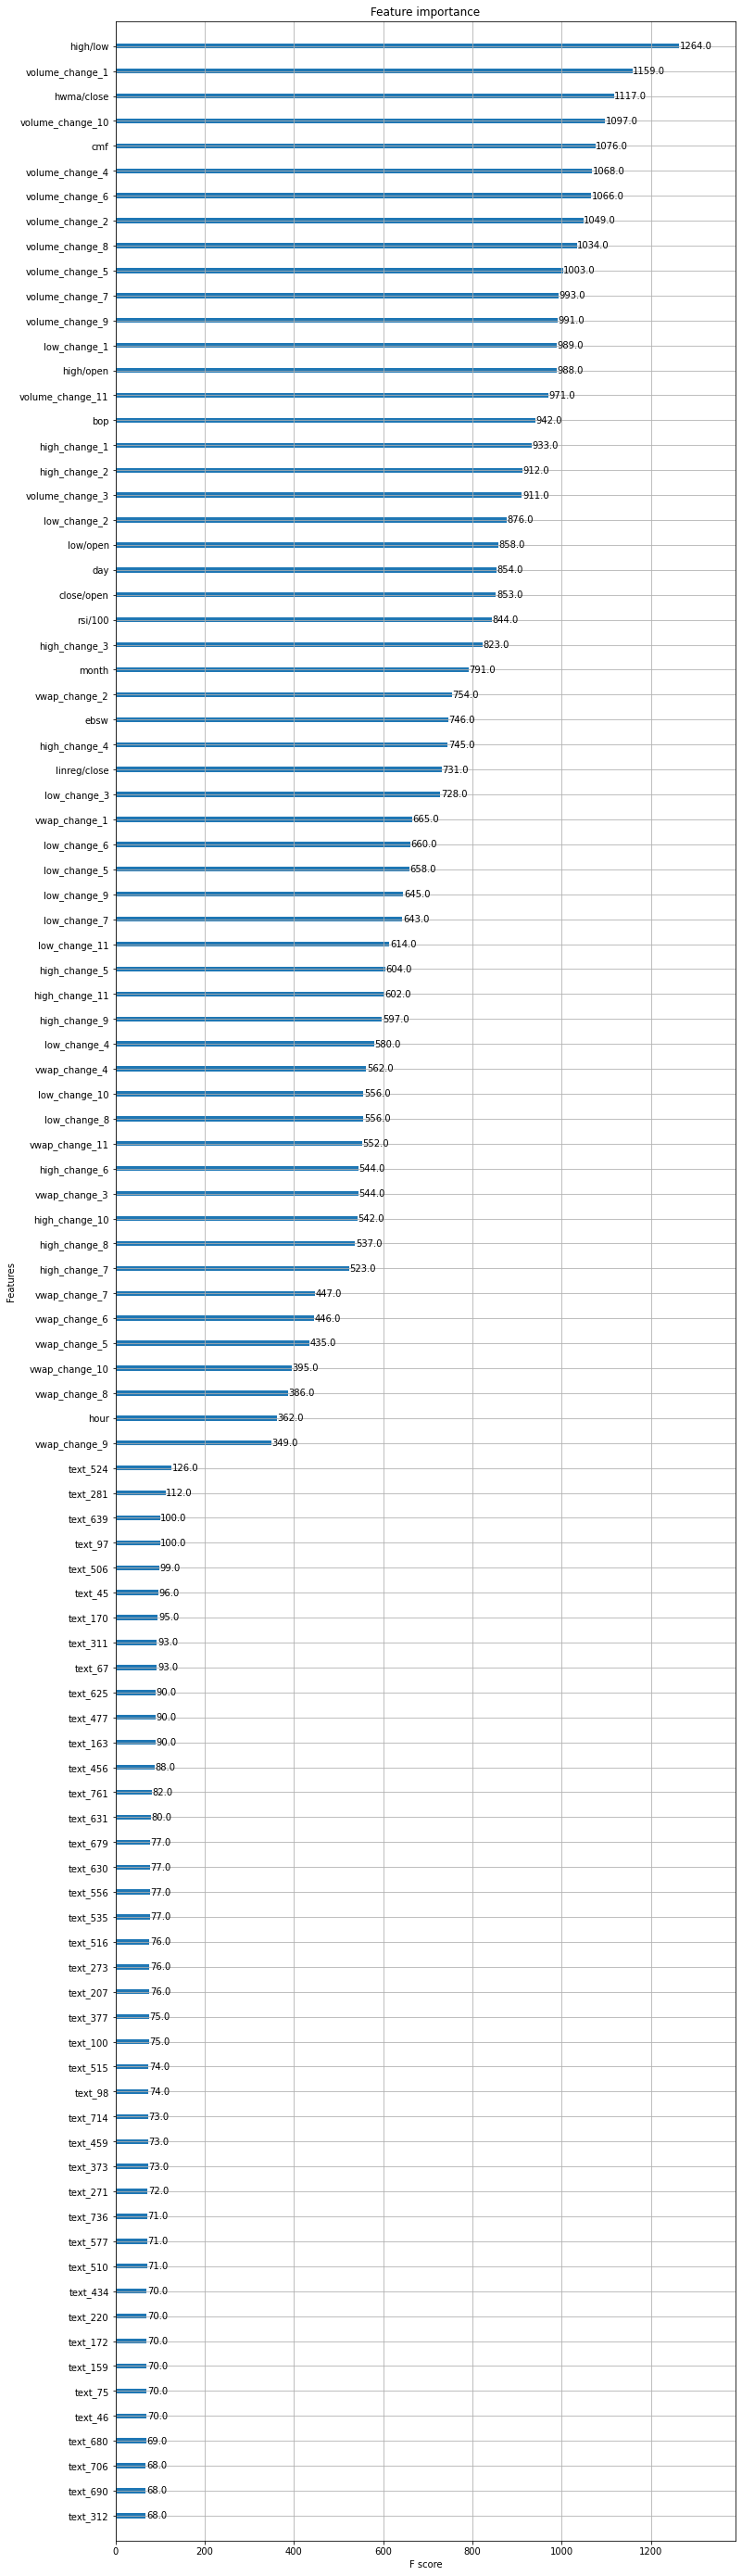

In [28]:
ax = xgboost.plot_importance(clf, max_num_features=100)
fig = ax.figure 
fig.set_size_inches(12, 50)

In [29]:
clf.save_model("xgboost_embeddings_model")